In [5]:
import PokUtils
import PokNet

random.seed(69)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

ModuleNotFoundError: No module named 'cv2'

In [2]:
import json
data = {"username":"trynottofly","key":"92f4117832fd8c85f41e37024984cd0f"}
with open('kaggle.json', 'w') as f:
    json.dump(data, f)

In [3]:
#! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download hlrhegemony/pokemon-image-dataset
#!kaggle datasets download trynottofly/animalwhiteback

 97% 56.0M/57.9M [00:03<00:00, 23.0MB/s]
100% 57.9M/57.9M [00:03<00:00, 17.5MB/s]


In [ ]:
! unzip "pokemon-image-dataset.zip"
#! unzip "animalwhiteback.zip"

In [6]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


def raise_edges(img, l=5, h=50, t="uint"):
    assert (t!="uint" or t!="float")
    if(t=="uint"):
      g_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      edges = cv2.Canny(g_img,l,h,L2gradient=True)
      img[edges.astype(bool), :] = 0
    elif(t=="float"):
      img = (255*img).astype(np.uint8)
      g_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      edges = cv2.Canny(g_img,l,h,L2gradient=True)
      img[edges.astype(bool), :] = 0
      img = img.astype(np.float32)/255
    return(img)

def smart_resize(img, size=256):
    if len(img.shape)==2:
      img=np.array(3*[img,])
      img = np.transpose(img, (1, 2, 0))

    max_sh = np.argmax(img.shape[:2])
    min_sh = np.argmin(img.shape[:2])
    max_sz = img.shape[max_sh]
    min_sz = img.shape[min_sh]
    delta = max_sz - min_sz
    new_img = 255*np.ones((max_sz, max_sz, 3)).astype(np.uint8)
    if (max_sh == 1):
      new_img[(delta//2):(min_sz+delta//2), :] = img
    else:
      new_img[:, (delta//2):(min_sz+delta//2)] = img
    new_img = resize(new_img,[size,size])
    return(new_img)


hflipper = T.RandomHorizontalFlip(p=0.5)
jitter = T.ColorJitter(brightness=0, hue=0.4)
affiner = T.RandomAffine(degrees=(-60, 60), translate=(0.05, 0.01), scale=(0.8, 0.9), fill=1)
grayer = T.Grayscale(num_output_channels=1)


def augmentation(img, n=4, to_gray=False, with_sharpness=None):
    img = torch.from_numpy(img.transpose(2,0,1)).to(dtype=torch.float)
    
    transforms=[hflipper, affiner]
    if to_gray:
      transforms.append(grayer)
    applier = T.RandomApply(transforms=transforms,p=1 )
    
    if with_sharpness is not None:
      img = T.functional.adjust_sharpness(img, sharpness_factor=5) 

    imgs = [applier(img) for _ in range(n)]
    return(imgs)


def build_pokemon_dataset(data_dirs=["images"], img_size=256,
                          aug_size=3, to_gray=False,
                          edges=None, with_sharpness=None,
                          memSTOP = 2):
    GiG = 2**30
    pokemon_dataset = []
    count = 0
    for data_dir in data_dirs:
      for dirpath, dirnames, filenames in tqdm(os.walk(data_dir)):
          for fname in filenames:
              if fname.endswith(".jpg"):
                  pokemon = skimage.io.imread(dirpath + "/" + fname)
                  pokemon = smart_resize(pokemon, size=img_size)
                  if edges is not None:
                      pokemon = raise_edges(pokemon, edges[0], edges[1], "float")
                  aug_pokemon = augmentation(pokemon, aug_size,
                                             to_gray=to_gray,
                                             with_sharpness=with_sharpness)
                  pokemon_dataset+=aug_pokemon
                  count += 1
          #if count>10:
          if (psutil.virtual_memory().available/(GiG) < memSTOP):   
              print(f"Only {memSTOP}GB system memory left :(")         
              random.shuffle(pokemon_dataset)
              pokemon_dataset = torch.stack(pokemon_dataset)
              pokemon_dataset = T.Normalize(*stats)(pokemon_dataset)
              return pokemon_dataset
    
    random.shuffle(pokemon_dataset)
    pokemon_dataset = torch.stack(pokemon_dataset)
    pokemon_dataset = T.Normalize(*stats)(pokemon_dataset)
    return pokemon_dataset      


def t2i(tens, indx=(1, 2, 0)):
    tens = torch.FloatTensor(tens)
    tens = tens.permute(indx[0], indx[1], indx[2])
    return(tens.numpy())    


def show_intermediate_results(autoencoder, val_loader, n=3):
  with torch.no_grad():
    for batch in val_loader:
      out = autoencoder(batch.to(device))
      if(type(out) is tuple):
          reconstruction, _,_ = out
      else:
          reconstruction = out    
      result = reconstruction.cpu().detach().numpy()
      ground_truth = batch.numpy()
      break      
  plt.figure(figsize=(6*n, 2))
  for i, (gt, res) in enumerate(zip(ground_truth[:n], result[:n])):
      plt.subplot(1, 2*n, 2*i+1)
      gt = t2i(gt)
      plt.imshow(gt)
      plt.subplot(1, 2*n, 2*i+2)
      res = t2i(res)
      plt.imshow(res)         
  plt.show()


def save_samples(gen, index, latent_tensors,sample_dir, show=True):
    gen.eval()
    fake_images = gen(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        nmax=64
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(fake_images.cpu().detach())[:nmax], nrow=8).permute(1, 2, 0))
        plt.show()
stats = (0.5, 0.5)


def denorm(img_tensors):
    return img_tensors * stats[0] + stats[1]


def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))


def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

In [15]:
def save_model(model, path_to_save_model, epoch):
    path_to_save_model_ = path_to_save_model + f"/epoch_{epoch}_{int(time.time()//60)-27963162}" 
    os.makedirs(path_to_save_model_, exist_ok=True)
    torch.save(model['discriminator'].state_dict(), path_to_save_model_ + "/discriminator")
    torch.save(model['generator'].state_dict(), path_to_save_model_ + "/generator") 


In [7]:
pokemons = build_pokemon_dataset(data_dirs=["images"], img_size=128,
                                 aug_size=8, to_gray=True,
                                 edges=None, with_sharpness=5,
                                 memSTOP = 3)

0it [00:00, ?it/s]

In [8]:
print(pokemons.shape)
print(pokemons.min(), pokemons.max())

torch.Size([20024, 1, 128, 128])
tensor(-1.) tensor(0.9998)


In [17]:
batch_size = 256
train_pokemons = pokemons
train_loader = torch.utils.data.DataLoader(train_pokemons, batch_size=batch_size, shuffle=True)
#show_batch(train_loader)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h1> **GAN Research**


<h3> ResNet

In [11]:
from functools import partial

class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)   
def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels


class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.BatchNorm2d(self.expanded_channels)) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

        
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.BatchNorm2d(out_channels))

class ResNetBasicBlock(ResNetResidualBlock):
    """
    Basic ResNet block composed by two layers of 3x3conv/batchnorm/activation
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

In [12]:
class ConvBlockGAN(nn.Module):
    def __init__(self, in_ch, out_ch, drop=0.0, bias=True):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=5, stride=2, padding=2,
                               padding_mode='replicate', bias=bias)
        self.act = nn.LeakyReLU(0.02, inplace=True)

        self.dropout = nn.Dropout2d(drop)
        self.normalization = nn.BatchNorm2d(out_ch)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.normalization(x)
        x = self.act(x)
        x = self.dropout(x)
        return x

class UnConvBlockGAN(nn.Module):
    def __init__(self, in_ch, out_ch, drop=0.0, bias=True):
        super().__init__()
        self.unconv1 = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=5, stride=2,
                                        padding=2, output_padding=1, bias=bias)
        self.act = nn.ReLU(True) #nn.LeakyReLU(0.02, inplace=True)
        self.dropout = nn.Dropout2d(drop)
        self.normalization = nn.BatchNorm2d(out_ch)
       
    def forward(self, x):
        x = self.unconv1(x)
        x = self.normalization(x)
        x = self.act(x)
        x = self.dropout(x)
        return x

In [13]:

class Noiser(nn.Module):
    def __init__(self, noise_coef=1.0e-3):
        super().__init__()
        self.noise_coef_ = noise_coef

    def add_noise_to_data(self, data):
        noise =  self.noise_coef_ * torch.randn(*(data.shape), device=device)
        data += noise
        return(data)

    def forward(self, x):
        #x = self.add_noise_to_data(x)
        x = x + torch.randn(*(x.shape), device=device)
        return x

In [66]:
class Discriminator128(nn.Module):
    def __init__(self, drop=0.0):
        super().__init__()
        
        self.core = nn.Sequential(
            # in: 3 x 128 x 128

            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 32 x 64 x 64
            ResNetBasicBlock(32, 32), 

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 4  x 4

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512), 
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 32 x 32


            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 x 1 x 1

            nn.Flatten(),
            nn.Sigmoid() )
        
    def forward(self, x):
        assert x.shape[-1] == 128
        x = self.core(x)
        return x


class Generator128(nn.Module):
    def __init__(self, latent_size, drop=0.0):
        super().__init__()
        
        self.noiser = Noiser(0.003)

        self.core = nn.Sequential(
            # in: latent_size x 1 x 1

            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # out: 1024 x 4 x 4
            ResNetBasicBlock(512, 1024),
            #nn.Dropout2d(drop_gen),

            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # out: 256 x 8 x 8
            ResNetBasicBlock(512, 256),
            #nn.Dropout2d(drop_gen)

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # out: 128 x 16 x 16
            ResNetBasicBlock(128, 128),
            #nn.Dropout2d(drop_gen),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # out: 64 x 32 x 32
            self.noiser,
            ResNetBasicBlock(64, 64),
            #nn.Dropout2d(drop_gen),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # out: 32 x 64 x 64
            ResNetBasicBlock(32, 32),
            
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # out: 3 x 128 x 128
        )
    def forward(self, x):
        x = self.core(x)
        return x

In [ ]:
#xb = torch.randn(17, 1, 128, 128) 
#a = Discriminator128()
#ans = a(xb)
#print(ans.shape)

In [ ]:
#xb = torch.randn(64, 512, 1, 1).to(device)
#b = Generator128(512).to(device)
#fake_images = b(xb)
#print(fake_images.shape)
#show_images(fake_images.cpu())

#del xb
#del b

In [75]:
def get_noise(size, noise_coef=1.0e-2):
    noise =  noise_coef * torch.randn(*size, device=device)
    return(noise)    

def get_noised_labels(size, type, noise_coef=1.0e-2):
    assert type!=1 or type!=0
    noise = torch.abs(get_noise(size, noise_coef))
    if type==1:
        labels = torch.ones(size, device=device)
        labels -= noise
        return(labels)
    if type==0:
        labels = torch.zeros(size, device=device)
        labels += noise
        return(labels)



In [68]:
def fit(model, criterion, epochs, lrs, latent_size,
        sample_dir=None, models_path=None,
        name="GoodModel", start_index=0):

    assert sample_dir!=None
    assert models_path!=None
    
    path_to_save_model = models_path + f"/{name}_model_at_{int(time.time()//60)-27963162}"
    os.makedirs(path_to_save_model, exist_ok=True)

    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lrs[0], betas=(0.4, 0.9)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lrs[1], betas=(0.4, 0.9))
    }
    
    labels_noise_coef = 0.03
    for epoch in range(start_index, epochs+start_index):
        #if (epoch==70):
        #    labels_noise_coef*=2
        #if (epoch%5==0):
        #    for g in optimizer["generator"].param_groups:
        #        g['lr'] *= 0.85   

        model["discriminator"].train()
        model["generator"].train()
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images in tqdm(train_loader):
            real_images = real_images.to(device)
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            #real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_targets = get_noised_labels([real_images.size(0), 1], 1, labels_noise_coef)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            #fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_targets = get_noised_labels([fake_images.size(0), 1], 0, labels_noise_coef)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            #targets = torch.ones(batch_size, 1, device=device)
            targets = get_noised_labels([batch_size, 1], 1)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Save generated images
        if (epoch<40):
            if epoch%5==0:
                clear_output(True)
                save_samples(model["generator"], epoch, fixed_latent, sample_dir=sample_dir, show=True)
                save_model(model, path_to_save_model, epoch)    
        elif(epoch>=40 and epoch<60):
            if epoch%2==0:
                clear_output(True)
                save_samples(model["generator"], epoch, fixed_latent, sample_dir=sample_dir, show=True)
                save_model(model, path_to_save_model, epoch)    
        else:
            clear_output(True)
            save_samples(model["generator"], epoch, fixed_latent, sample_dir=sample_dir, show=True)  
            save_model(model, path_to_save_model, epoch)    

    

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
    
    return losses_g, losses_d, real_scores, fake_scores

In [69]:
import shutil
sample_dir = 'drive/MyDrive/NN/generated'
if os.path.exists(sample_dir):
  shutil.rmtree(sample_dir)
os.makedirs(sample_dir, exist_ok=True)

models_path = "drive/MyDrive/NN/models"
os.makedirs(models_path, exist_ok=True)

In [70]:
drop_dis = 0.0
drop_gen = 0.0
latent_size = 256

model = {
    "discriminator": Discriminator128().to(device),
    "generator": Generator128(latent_size=latent_size, drop=drop_gen).to(device)
}

criterion = {
    "discriminator": nn.BCELoss(), #nn.MSELoss(reduction='sum'), 
    "generator":  nn.BCELoss(), #nn.MSELoss(reduction='sum'), #nn.BCELoss()
}
index=0

print('Количество параметров discriminator',
      sum(np.product(t.shape) for t in model["discriminator"].parameters()))
print('Количество параметров generator',
      sum(np.product(t.shape) for t in model["generator"].parameters()))

Количество параметров discriminator 2814528
Количество параметров generator 28153152


In [71]:
 model["discriminator"].load_state_dict(torch.load("/content/drive/MyDrive/NN/models/BigGen/epoch_81_2939/discriminator"))
 model["generator"].load_state_dict(torch.load("/content/drive/MyDrive/NN/models/BigGen/epoch_81_2939/generator"))

<All keys matched successfully>

In [73]:
epochs = 120
lrs = [0.001, 0.001]
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0068.png


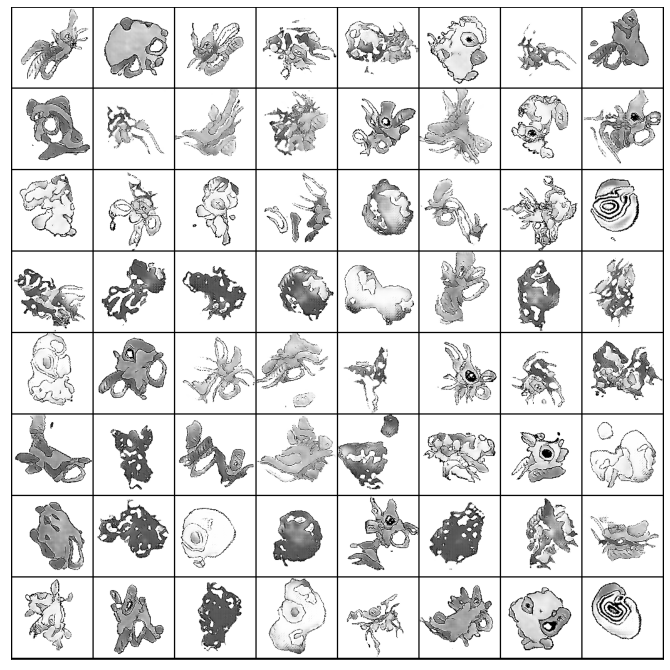

Epoch [69/120], loss_g: 4.1140, loss_d: 0.2768, real_score: 0.9593, fake_score: 0.0404


  0%|          | 0/79 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [74]:
history = fit(model, criterion, epochs, lrs, latent_size, sample_dir=sample_dir,
              models_path=models_path, name="BigGen_0303_128", start_index=60)

In [ ]:
#shutil.rmtree("models")


In [59]:
TESTgen = Generator128(latent_size=latent_size, drop=drop_gen).to(device)
TESTgen.load_state_dict(
    torch.load(
        "/content/drive/MyDrive/NN/models/BigGen/epoch_81_2939/generator"))
TESTgen.eval()
1

1

Saving generated-images-0000.png


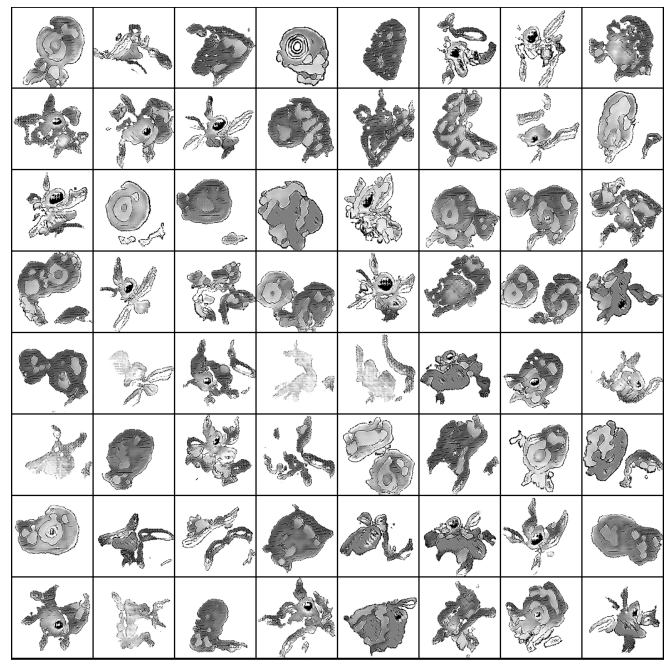

Saving generated-images-0001.png


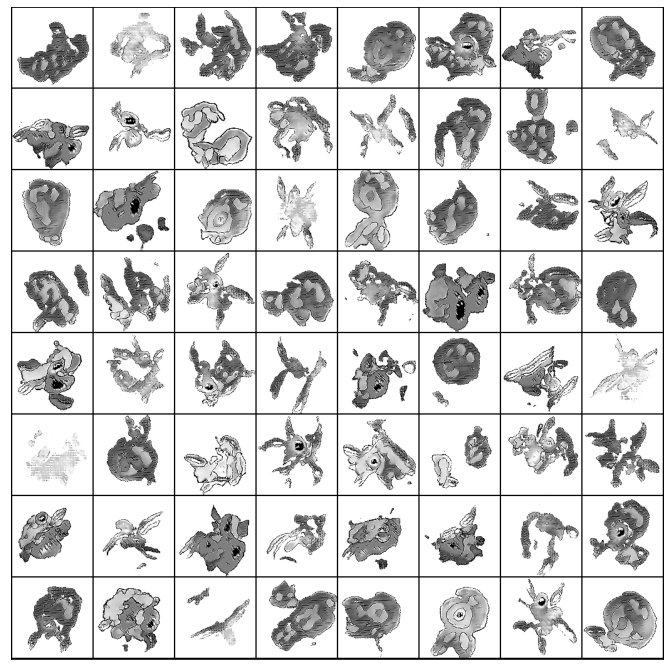

Saving generated-images-0002.png


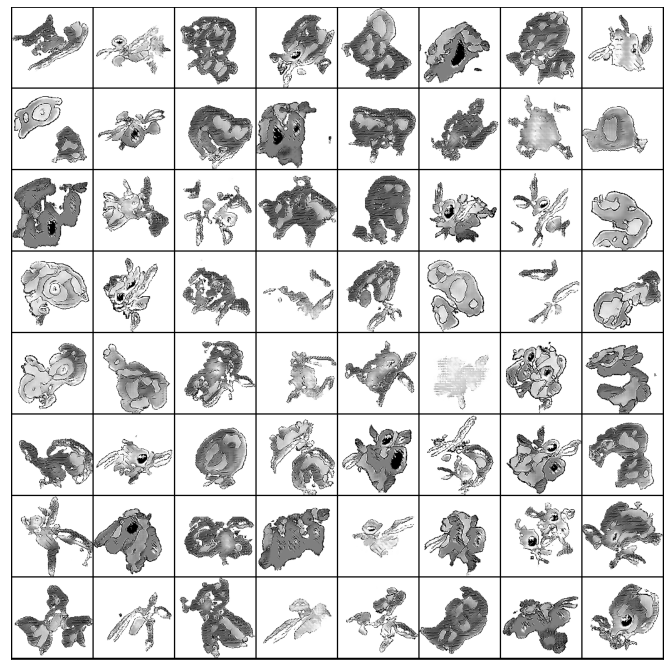

Saving generated-images-0003.png


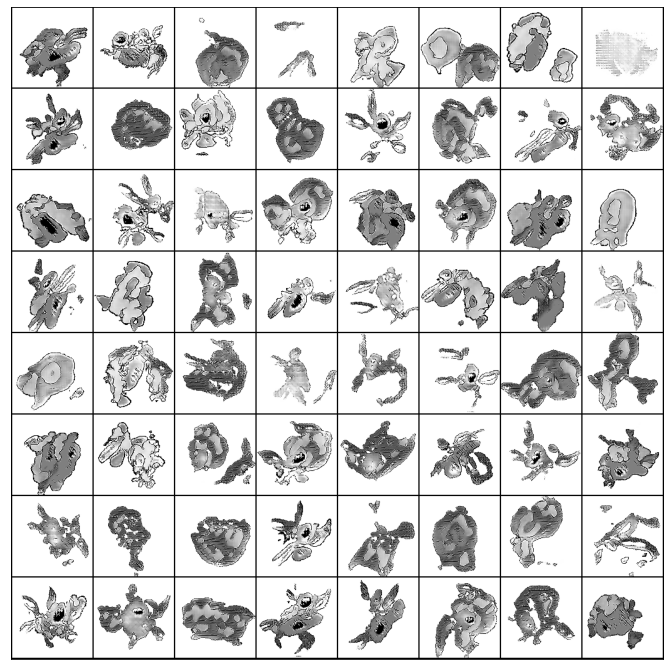

Saving generated-images-0004.png


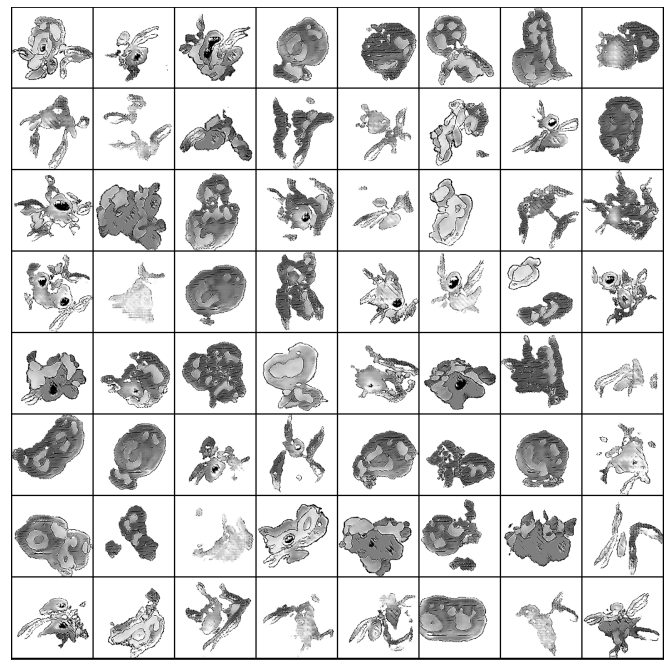

Saving generated-images-0005.png


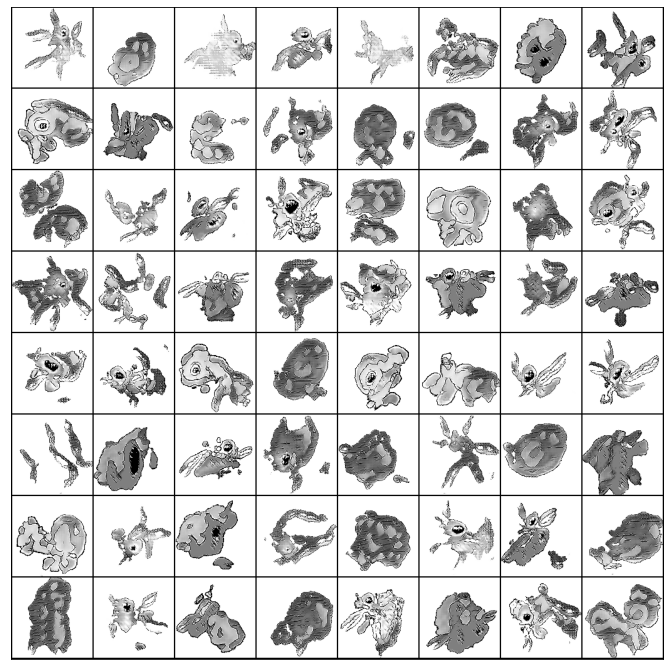

Saving generated-images-0006.png


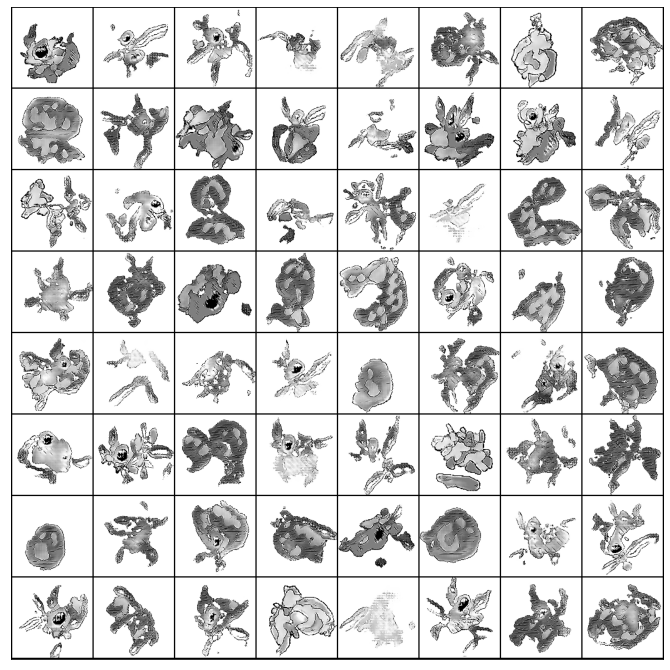

Saving generated-images-0007.png


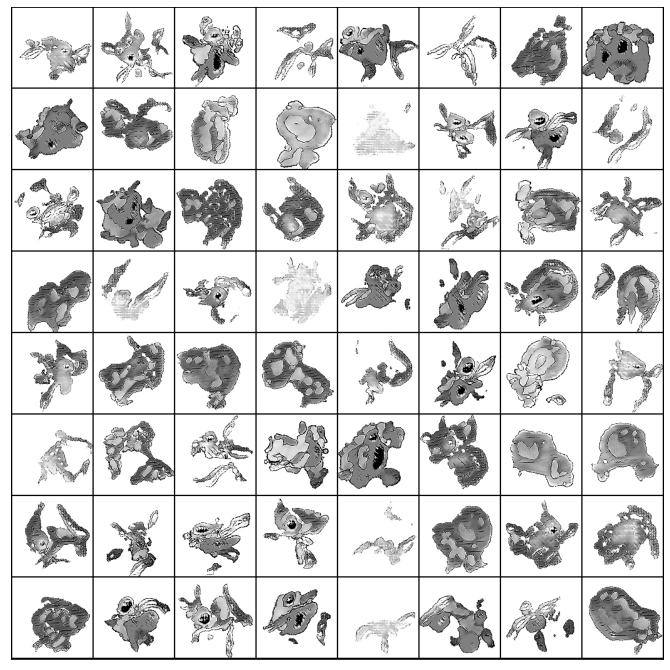

Saving generated-images-0008.png


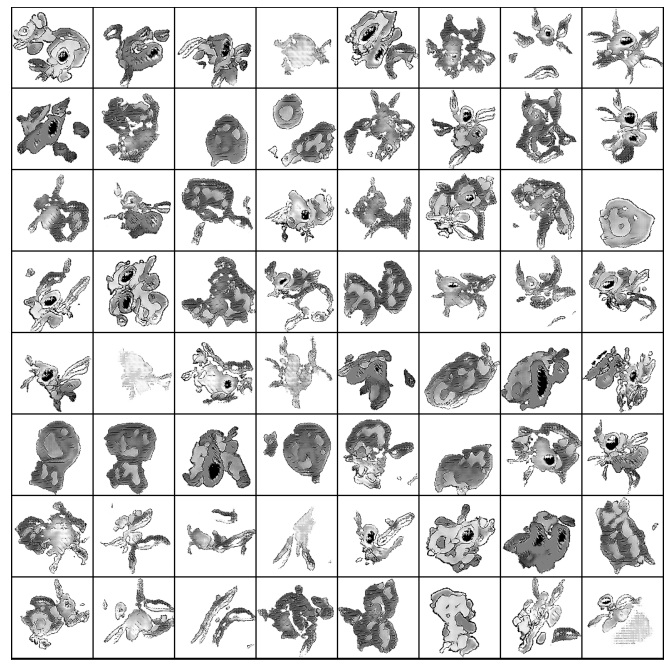

Saving generated-images-0009.png


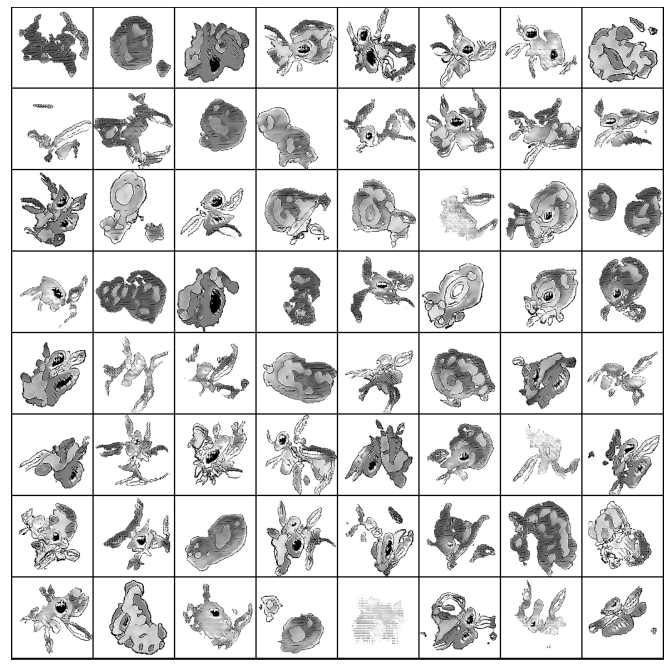

In [60]:
dir = "/content/drive/MyDrive/NN/test"
os.makedirs(dir, exist_ok=True)   
for i in range(10):
    fixed_test = torch.randn(64, latent_size, 1, 1, device=device)
    save_samples(TESTgen, i, fixed_test, sample_dir=dir, show=True)

In [ ]:
#loaded_model = TheModelClass(*args, **kwargs)
#loaded_model.load_state_dict(torch.load(PATH))
#loaded_model.eval()

In [ ]:
class Discriminator64(nn.Module):
    def __init__(self, drop=0.0):
        super().__init__()
        
        self.core = nn.Sequential(
            # in: 3 x 64 x 64

            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 4 x 4

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 x 1 x 1

            nn.Flatten(),
            nn.Sigmoid() 
            )
        
    def forward(self, x):
        x = self.core(x)
        return x

class Generator64(nn.Module):
    def __init__(self, latent_size, drop=0.0):
        super().__init__()
        
        self.core = nn.Sequential(
        # in: latent_size x 1 x 1

        nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        # out: 512 x 4 x 4
        #ResNetBasicBlock(512, 512),

        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        # out: 256 x 8 x 8
        ResNetBasicBlock(256, 256),

        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # out: 128 x 16 x 16

        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # out: 64 x 32 x 32
        ResNetBasicBlock(64, 32),

        # out: 3 x 64 x 64    

        nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh() 
        )

    def forward(self, x):
        x = self.core(x)
        return x    
    

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

TypeError: ignored

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
discriminator_128 = nn.Sequential(
    ConvBlockGAN(1, 32, drop=drop_dis, bias=False),
    # 32 x 64 x 64
    #ResNetBasicBlock(32, 48),
    # 48 x 64 x 64
    
    ConvBlockGAN(32, 64, drop=drop_dis, bias=False),
    # 48 x 32 x 32
    #ResNetBasicBlock(64, 96),
    # 64 x 32 x 32
    
    ConvBlockGAN(64, 128, drop=drop_dis, bias=False),
    # 96 x 16 x 16
    #ResNetBasicBlock(128, 128),
    # 128 x 16 x 16
    
    ConvBlockGAN(128, 256, drop=drop_dis, bias=False),
    # 192 x 8 x 8
    #ResNetBasicBlock(192, 256),
    # 256 x 8 x 8
    
    ConvBlockGAN(256, 512, drop=drop_dis, bias=False),
    # 512 x 4 x 4
    #ResNetBasicBlock(512, 512),
    # 512 x 4 x 4

    #nn.Flatten(),
    #nn.Linear(512*4*4, 512),
    #nn.Linear(512, 1),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    
    nn.Flatten(),
    nn.Sigmoid(),
    # out: 1 x 1 x 1
    )

generator_128 = nn.Sequential(
    # in: latent_size x 1 x 1
    
    #nn.Flatten(),
    #nn.Linear(latent_size, 512),
    #nn.Linear(latent_size, 512*2*2),
    #nn.Unflatten(dim=1, unflattened_size=(512,2,2)),

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),  
    # 512 x 4 x 4
    ResNetBasicBlock(512, 512),
    # 256 x 4 x 4

    UnConvBlockGAN(512, 256, drop=drop_gen, bias=False),
    # 192 x 8 x 8
    ResNetBasicBlock(256, 256),
    # 128 x 8 x 8

    UnConvBlockGAN(256, 128, drop=drop_gen, bias=False),
    # 96 x 16 x 16
    #ResNetBasicBlock(192, 128),
    # 64 x 16 x 16

    UnConvBlockGAN(128, 64, drop=drop_gen, bias=False),
    # 64 x 32 x 32
    #ResNetBasicBlock(96, 64),
    # 64 x 32 x 32

    UnConvBlockGAN(64, 32, drop=drop_gen, bias=False),
    # 48 x 64 x 64
    #ResNetBasicBlock(48, 32),
    # 32 x 64 x 64

    UnConvBlockGAN(32, 1, drop=drop_gen, bias=False),
    # 1 x 128 x 128
    
    #nn.Sigmoid()
    nn.Tanh()
)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_size, channels):
        super().__init__()        
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=5, stride=1, padding=2, padding_mode='replicate'),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(32),
  
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2, padding_mode='replicate'),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2, padding_mode='replicate'),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2, padding_mode='replicate'),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2, padding_mode='replicate'),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(512),
        )

        self.flatten = nn.Flatten()
        
        self.encoder_lin = nn.Sequential(
            nn.Linear(in_features=4*4*512, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.SELU(),
            nn.Linear(in_features=1024, out_features=latent_size*2),
        )

    def forward(self, x):
        x = self.encoder_conv(x)
        x = self.flatten(x).float()
        x = self.encoder_lin(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_size, channels):
        super().__init__()

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(512,4,4))
        
        self.decoder_lin = nn.Sequential(
            nn.Linear(in_features=latent_size, out_features=1024),
            nn.SELU(),
            nn.BatchNorm1d(1024),
            nn.Linear(in_features=1024, out_features=4*4*512),
        )
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(256),
            
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(32),
          
            nn.ConvTranspose2d(32, channels, kernel_size=5, stride=1, padding=2, output_padding=0),
            nn.Sigmoid(),
            nn.BatchNorm2d(channels),
        )


    def forward(self, x, pool_data=None):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        return x       

         
class VAE64(nn.Module):
    def __init__(self, latent_size=512, channels=3):

        super().__init__()

        self.encoder = Encoder(latent_size, channels)
        self.decoder = Decoder(latent_size, channels) 
        self.latent_size = latent_size

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1, 2, self.latent_size)
        mu = x[:, 0, :] 
        log_var = x[:, 1, :] 
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decoder(z)
        return reconstruction, mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var) 
        eps = torch.randn_like(std) 
        sample = mu + (eps * std) 
        return sample    

    def sample(self, z):
        generated = self.decoder(z)
        return generated

    def get_latent_vector(self, x):
        x = self.encoder(x)
        x = x.view(-1, 2, latent_size)
        mu = x[:, 0, :] 
        log_var = x[:, 1, :]
        z = self.reparameterize(mu, log_var)
        return z

In [ ]:
class LinearVAE(nn.Module):
    def __init__(self, features):
        super(LinearVAE, self).__init__()
        self.features = features
        self.flatten = nn.Flatten()
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(3,64,64))
 
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=12288, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=self.features*2)
        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.features, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=12288),
            nn.Sigmoid()
        )
 
    def forward(self, x):
        # encoding
        x = self.flatten(x).float()
        x = self.encoder(x)
        x = x.view(-1, 2, self.features)
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        x = self.reparameterize(mu, log_var)
        # decoding
        x = self.decoder(x)
        x = self.unflatten(x).float()
        return x, mu, log_var

    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample

    def sample(self, z):
        generated = self.decoder(z)
        return generated

    def get_latent_vector(self, x):
        x = self.flatten(x).float()
        x = self.encoder(x)
        x = x.view(-1, 2, self.features)
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        z = self.reparameterize(mu, log_var)
        return z

class LinearAE(nn.Module):
    def __init__(self, features):
        super(LinearAE, self).__init__()
        self.features = features
        self.flatten = nn.Flatten()
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(1,64,64))
 
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=1*64*64, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=self.features)
        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.features, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=1*64*64),
            nn.Sigmoid()
        )
 
    def forward(self, x):
        # encoding
        x = self.flatten(x).float()
        x = self.encoder(x)

        # decoding
        x = self.decoder(x)
        x = self.unflatten(x).float()
        return x


    def sample(self, z):
        generated = self.decoder(z)
        return generated

    def get_latent_vector(self, x):
        x = self.flatten(x).float()
        x = self.encoder(x)
        return x     

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, drop=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=5, stride=2, padding=2,
                               padding_mode='replicate')
        self.act = nn.LeakyReLU(0.02)

        #self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, 
        #                       stride=1, padding=1, padding_mode='replicate')
        self.dropout = nn.Dropout2d(drop)
        self.normalization = nn.BatchNorm2d(out_ch)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.normalization(x)
        x = self.act(x)
        x = self.dropout(x)
        
        #x = self.conv2(x)
        #x = self.normalization(x)
        #x = self.act(x)
        #x = self.dropout(x)
        return x

class UnConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, drop=0.0):
        super().__init__()
        self.unconv1 = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=5, stride=2,
                                        padding=2, output_padding=1)
        self.act = nn.LeakyReLU(0.02)
        #self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, 
        #                       stride=1, padding=1, padding_mode='replicate')
        self.dropout = nn.Dropout2d(drop)
        self.normalization = nn.BatchNorm2d(out_ch)
       
    def forward(self, x):
        x = self.unconv1(x)
        x = self.normalization(x)
        x = self.act(x)
        x = self.dropout(x)
        #x = self.conv2(x)
        #x = self.normalization(x)
        #x = self.relu(x)
        #x = self.dropout(x)
        return x

class ConvEncoder(nn.Module):
    def __init__(self, channels):
        super().__init__()        

        self.encoder_conv = nn.Sequential(
            ConvBlock(channels, 16),
            ConvBlock(16, 32),
            ConvBlock(32, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256),
        )

        #self.flatten = nn.Flatten()
        
        #self.encoder_lin = nn.Sequential(
        #    nn.Linear(in_features=4*4*512, out_features=1024),
        #    nn.BatchNorm1d(1024),
        #    nn.SELU(),
        #    nn.Linear(in_features=1024, out_features=latent_size*2),
        #)

    def forward(self, x): 
        x = self.encoder_conv(x)
        #x = self.flatten(x).float()
        return x

class ConvDecoder(nn.Module):
    def __init__(self, channels):
        super().__init__()        

        self.sigmoid = nn.Sigmoid()

        self.decoder_conv = nn.Sequential(
            UnConvBlock(256, 128),
            UnConvBlock(128, 64),
            UnConvBlock(64, 32),
            UnConvBlock(32, 16),
            UnConvBlock(16, channels),
        )

        #self.flatten = nn.Flatten()
        
        #self.encoder_lin = nn.Sequential(
        #    nn.Linear(in_features=4*4*512, out_features=1024),
        #    nn.BatchNorm1d(1024),
        #    nn.SELU(),
        #    nn.Linear(in_features=1024, out_features=latent_size*2),
        #)

    def forward(self, x):
        x = self.decoder_conv(x)
        x = self.sigmoid(x)
        #x = self.flatten(x).float()
        return x

class ConvAE64(nn.Module):
    def __init__(self, features, channels=3):
        super().__init__()
        
        self.encoder = ConvEncoder(channels)
        self.decoder = ConvDecoder(channels)
        
        #self.flatten = nn.Flatten()
        #self.relu = nn.ReLU()

    def forward(self, x):
        #print(x.shape) 
        x = self.encoder(x)
        print(x.shape)
        x = self.decoder(x)
        return x   

    def sample(self, x):
        x = self.decoder(x)
        return x

In [ ]:
test = VAE64(32, channels=1)
#test = LinearVAE(32)
#test = LinearAE(32)
#test = ConvAE64(32, channels=1)
x  = torch.randn(11, 1, 64, 64)
print('Количество параметров сети', sum(np.product(t.shape) for t in test.parameters()))
#x, mu, logsigma = test(x)
x = test(x)

print(x[0].shape)

Количество параметров сети 25599939
torch.Size([11, 1, 64, 64])


Определим лосс и его компоненты для VAE:

Из лекций вы узнали, что лосс у VAE состоит из двух частей: KL-дивергенции, отвечающей за то, как далеко друг от друга отстоят распределения, соответствующие разным лицам, и log-likelihood, отвечающий за то, насколько хорошо мы кодируем исходное изображение.
Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def MSE(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.MSELoss(reduction='sum')
    return loss(reconstruction, x)

def sharpness_loss(reco, sigma=0.3):
    gaussblur = T.GaussianBlur(3, sigma=(sigma, sigma))
    reco_blured = gaussblur(reco)
    return -10*torch.sum((reco_blured-reco)**2) 

def loss_vae(x, mu, logsigma, reconstruction):
    KL_loss = KL_divergence(mu, logsigma)
    #MSE_loss = MSE(x, reconstruction)
    #SR_loss = sharpness_loss(reconstruction)
    LH_loss = log_likelihood(x, reconstruction)

    return LH_loss + KL_loss #+ 64*64**SR_loss 

def get_all_losses(x, mu, logsigma, reconstruction):
    KL_loss = KL_divergence(mu, logsigma)
    MSE_loss = MSE(x, reconstruction)
    SR_loss = sharpness_loss(reconstruction)
    return MSE_loss, torch.abs(SR_loss), KL_loss

И обучим модель:

In [ ]:
criterion = loss_vae
img_size = 64
latent_size = 16
autoencoder = VAE64(latent_size, channels=1).to(device)
#autoencoder = LinearVAE(latent_size).to(device)
#autoencoder = LinearAE(latent_size).to(device)
#autoencoder = ConvAE64(latent_size, channels=1).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

#print(autoencoder.parameters)
print('Количество параметров сети', sum(np.product(t.shape) for t in autoencoder.parameters()))

RuntimeError: ignored

In [ ]:
n_epochs = 200
train_losses = []
MSE_losses = []
SR_losses = []
KL_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()

    train_losses_per_epoch = []
    MSE_per_epoch = []
    SR_per_epoch = []
    KL_per_epoch = []

    for batch in train_loader:
        optimizer.zero_grad()
        reconstruction, mu, logsigma = autoencoder(batch.to(device))
        #reconstruction = autoencoder(batch.to(device))
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        #loss = MSE(batch.to(device).float(), reconstruction)
        
        loss.backward()
        optimizer.step()

        #result_ = reconstruction.cpu().detach()
        #mu_ = mu.cpu().detach() #torch.tensor(0.0)
        #logsigma_ = logsigma.cpu().detach() #logsigma.cpu().detach()
        #ground_truth_ = batch.cpu().detach()

        #(MSE_loss, SR_loss, KL_loss) = get_all_losses(ground_truth_, mu_, logsigma_, result_)

        #train_losses_per_epoch.append(loss.item())
        #MSE_per_epoch.append(MSE_loss.item())
        #SR_per_epoch.append(SR_loss.item())
        #KL_per_epoch.append(KL_loss.item())

    #train_losses.append(np.mean(train_losses_per_epoch))
    #MSE_losses.append(np.mean(MSE_per_epoch))
    #SR_losses.append(np.mean(SR_per_epoch))
    #KL_losses.append(np.mean(KL_per_epoch))


    if (1):#(epoch + 1) % 2 == 0:
        #clear_output(True)
        autoencoder.eval()
        show_intermediate_results(autoencoder)

        #plt.semilogy(train_losses, label='loss')
        #plt.semilogy(MSE_losses, label='MSE')
        #plt.semilogy(SR_losses, label='SR')
        #plt.semilogy(KL_losses, label='KL')

        plt.legend()
        plt.show()



  0%|          | 0/200 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
autoencoder.eval()
with torch.no_grad():
      for batch in val_loader:
        #reconstruction, _, _ = autoencoder(batch.to(device))
        reconstruction = autoencoder(batch.to(device))
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch.numpy()
        break

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
    plt.subplot(5, 2, 2*i+1)
    gt = t2i(gt)
    plt.imshow(gt)
    plt.subplot(5, 2, 2*i+2)
    res = t2i(res)
    plt.imshow(res)     



## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
#z = np.array([np.random.normal(0, 1, latent_size).astype(np.float32) for i in range(10)])
#z = np.array([np.random.normal(256, 2, 2).astype(np.float32) for i in range(10)])
z  = torch.randn(10, 256, 2, 2)
print(z.shape)
output = autoencoder.sample(torch.FloatTensor(z).to(device))

In [ ]:
plt.figure(figsize=(18, 18))
for i in range(output.shape[0]):
  plt.subplot(output.shape[0] // 2, 2, i + 1)
  generated = output[i].cpu().detach().numpy()
  generated = t2i(generated)
  plt.imshow(generated)


plt.show()

## Еще немного экспериментов

Сгенерируем латентные векторы для двух изображений

In [ ]:
gt_0 = torch.FloatTensor([ground_truth[0]]).to(device)
gt_1 = torch.FloatTensor([ground_truth[1]]).to(device)

In [ ]:
first_latent_vector = autoencoder.get_latent_vector(gt_0)
second_latent_vector = autoencoder.get_latent_vector(gt_1)

In [ ]:
i_1 = autoencoder.sample(first_latent_vector)[0].cpu().detach().numpy()
i_1 = t2i(i_1)
plt.imshow(i_1)

In [ ]:
i_2 = autoencoder.sample(second_latent_vector)[0].cpu().detach().numpy()
i_2 = t2i(i_2)
plt.imshow(i_2)


Теперь посмотрим, как будет выглядеть их *выпуклая комбинация*: $\alpha l_1 + (1 - \alpha)l_2$, где $l_1, l_2$ – латентные векторы, $\alpha \in [0, 1]$

In [ ]:
plt.figure(figsize=(18, 5))
for i, alpha in enumerate(np.linspace(0., 1., 5)):
  plt.subplot(1, 5, i + 1)
  latent = (1 - alpha) * first_latent_vector + alpha * second_latent_vector
  img = autoencoder.sample(latent)[0].cpu().detach().numpy()
  img = t2i(img)
  plt.imshow(img)

In [ ]:
!pip install git+https://github.com/lukemelas/pytorch-pretrained-gans

In [ ]:
from pytorch_pretrained_gans import make_gan

# Sample a class-conditional image from BigGAN with default resolution 256
G = make_gan(gan_type='biggan')  # -> nn.Module
y = G.sample_class(batch_size=1)  # -> torch.Size([1, 1000])
z = G.sample_latent(batch_size=1)  # -> torch.Size([1, 128])
x = G(z=z, y=y)